In [1]:
import networkx as nx
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
from copy import deepcopy 
import time
import multiprocessing

In [2]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)


In [3]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        return g

In [4]:
g = read_graph(file_path='wi29.tsp')
len(g.edges)

406

In [5]:
class Indivudal:
    def __init__(self, g):
        num_of_cities = len(g.nodes)
        self.code = np.random.permutation(num_of_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
    def __lt__(self, other):
         return self.fitness < other.fitness
    
    def calc_fitness(self, g):
        dis = 0
        n = len(self.code)
        for i in range(n-1):
            dis += g[self.code[i]][self.code[i+1]]["distance"]
    
        dis += g[self.code[-1]][self.code[0]]["distance"]
        
        return dis

In [6]:
i = Indivudal(g)
i.fitness

107204.55204817385

In [7]:
def mutation(individual, mutation_prob):
    
    do = random.random() <= mutation_prob

    if do:
        n = len(individual.code)
        idx1 = random.randrange(n)
        #lista bez idx1
        allowed = list(set(range(n)).difference({idx1}))
        idx2 = random.choice(allowed)
        temp = individual.code[idx1]
        individual.code[idx1] = individual.code[idx2]
        individual.code[idx2] = temp
        

In [8]:
def selection(population, tournament_size,other_parent=None):
    allowed = list(set(range(len(population))).difference({other_parent}))
    chosen = random.sample(allowed, tournament_size)
    max_fitness = float('inf')
    winner_idx = None
    for idx in chosen:
        if max_fitness > population[idx].fitness:
            winner_idx = idx
            max_fitness = population[idx].fitness
    return winner_idx

In [9]:
#ne radi
def crossover(parent1, parent2,child1,child2):
    #ukrstanje prvog reda
    size = len(parent1.code)
    start, end = sorted(random.sample(range(size), 2))

    child1.code = [-1 for _ in range(size)]
    child2.code = [-1 for _ in range(size)]

    # Kopiraj segment između start i end iz roditelja
    child1.code[start:end] = parent1.code[start:end]
    child2.code[start:end] = parent2.code[start:end]

    # Indeksi za popunjavanje preostalih vrednosti
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 1 s vrednostima iz drugog roditelja
    while idx1 != start:
        if parent2.code[idx2] not in child1.code:
            child1.code[idx1] = parent2.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

    # Indeksi za popunjavanje preostalih vrednosti u detetu 2
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 2 s vrednostima iz prvog roditelja
    while idx1 != start:
        if parent1.code[idx2] not in child2.code:
            child2.code[idx1] = parent1.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

In [10]:
p1 = Indivudal(g)
p2 = Indivudal(g)
c1 = Indivudal(g)
c2 = Indivudal(g)

In [11]:
print(p1.code)
print(p2.code)

crossover(p1,p2,c1,c2)
print(c1.code)
print(c2.code)

[18, 14, 20, 3, 17, 22, 23, 16, 4, 5, 24, 19, 7, 25, 2, 9, 15, 0, 27, 8, 12, 26, 1, 28, 11, 10, 13, 6, 21]
[18, 19, 15, 8, 9, 12, 20, 26, 14, 22, 3, 6, 1, 13, 25, 11, 27, 28, 7, 21, 4, 5, 16, 24, 0, 17, 2, 10, 23]
[18, 20, 14, 22, 3, 21, 4, 5, 16, 24, 17, 19, 7, 25, 2, 9, 15, 0, 27, 8, 12, 26, 1, 28, 11, 10, 13, 6, 23]
[14, 20, 3, 22, 23, 19, 9, 15, 8, 12, 26, 6, 1, 13, 25, 11, 27, 28, 7, 21, 4, 5, 16, 24, 0, 17, 2, 10, 18]


In [12]:
def crossover1(parent1, parent2,child1,child2):
    
    n = len(parent1.code)
    child1_list = []
    child2_list = []
    
    breakpoint = random.randrange(n)
    
    child1_list.extend(parent1.code[:breakpoint])
    child2_list.extend(parent2.code[:breakpoint])
    
    for i in range(breakpoint,n):
        if parent2.code[i] not in child1_list:
            child1_list.append(parent2.code[i])
        if parent1.code[i] not in child2_list:
            child2_list.append(parent1.code[i])
        
    
    for node in parent2.code:
        if node not in child1_list:
            child1_list.append(node)
    for node in parent1.code:
        if node not in child2_list:
            child2_list.append(node)
            
    child1.code,child2.code = child1_list,child2_list

In [13]:
def simple_ga(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
            
        for i in range(elitism_size, pop_size, 2):
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses

In [25]:
start = time.time()
best_fitnesses = simple_ga(g,1000,100,5,0.05,True,10,10)
end = time.time()
print(f"Execution time {end - start}s")

Best individual time:
[17, 10, 9, 5, 1, 0, 4, 12, 25, 27, 28, 18, 14, 11, 7, 3, 2, 6, 8, 13, 15, 23, 26, 24, 19, 16, 20, 22, 21]
Fitness of best indvidual 37021.721222139066
2.701116984809442e-05
Execution time 3.498539924621582s


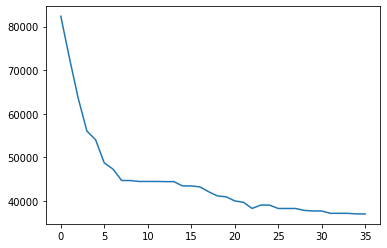

In [26]:
plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)

In [27]:
def local_search(individual,max_iterations=10):
    for _ in range(max_iterations):
        old_fitness = individual.fitness
        i, j = random.sample(range(len(individual.code)), 2)
        individual.code[i], individual.code[j] = individual.code[j], individual.code[i]
        new_fitness = individual.fitness
        if old_fitness < new_fitness:
            individual.code[i], individual.code[j] = individual.code[j], individual.code[i]
            
    return individual, individual.fitness

In [28]:
i, ifit = local_search(Indivudal(g),10)

In [29]:
print(i.code)
print(ifit)

[1, 21, 11, 22, 23, 7, 25, 27, 10, 2, 26, 28, 19, 4, 5, 13, 16, 9, 6, 12, 24, 0, 8, 14, 15, 20, 18, 17, 3]
103823.6904079324


In [30]:
def GA_with_LS(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses, best_individual

In [31]:
start = time.time()
best_fitnesses,_ = GA_with_LS(g,1000,80,5,0.05,True,10,10,10)
end = time.time()
print(f"Execution time {end - start}s")

Best individual time:
[13, 23, 12, 1, 18, 7, 10, 24, 14, 22, 15, 6, 16, 20, 9, 5, 25, 11, 17, 26, 19, 27, 8, 2, 3, 21, 4, 28, 0]
Fitness of best indvidual 36858.005327239945
2.7131148067335836e-05
Execution time 13.380713701248169s


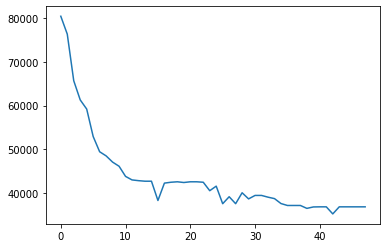

In [32]:
plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)

In [33]:
def GA_with_LS_single(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    result = best_individual.fitness, best_individual.code
    result_queue.put(result)


In [34]:
def parallel_ga_ls(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,num_processes):
    # Create a list of arguments for each process
    processes = []
    result_queue = multiprocessing.Queue()
    for i in range(num_processes):
        args = (g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue)
        process = multiprocessing.Process(target=GA_with_LS_single, args=args)
        process.start()
   
        processes.append(process)

    # Start and join all processes
    #for process in processes:
    #    process.start()


    for process in processes:
        process.join()
    results = []
    while not result_queue.empty():
        result = result_queue.get()
        results.append(result)
    print("\\\\")
    results.sort()
    print(f"fitnes najbolje {results[0][0]}")
    print(f"Kod najbolje jedinke {results[0][1]}")
     
  
    

In [35]:
if __name__ == "__main__":

    # ga_ls( graph,
    #     num_iters = 20,
    #     use_elitism = True,
    #     population_size = 1000,
    #     elitism_size = 10,
    #     mutation_prob = 0.15,
    #     tournament_size = 10,
    # )
    
    multiprocessing.freeze_support()  
    
    start = time.time()

    parallel_ga_ls( g,
        num_iters = 20,
        use_elitism = True,
        pop_size = 1000,
        elitism_size = 10,
        mutation_prob = 0.15,
        tournament_size = 10,
        Stop = 10,
        local_size = 10,
        num_processes = 4
    )
    
    end = time.time()
    
    print(f"Vreme {end-start}s")

\\
fitnes najbolje 31561.052735274312
Kod najbolje jedinke [11, 7, 8, 6, 2, 3, 4, 0, 1, 5, 12, 13, 16, 20, 21, 22, 28, 27, 25, 26, 23, 24, 15, 19, 17, 18, 14, 10, 9]
Vreme 11.436898946762085s
